## Imports y datasets

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

import pickle

RANDOM_STATE = 42

In [7]:
original = pd.read_csv('Datasets/hotels_procesado.csv').copy()
original_test = pd.read_csv('Datasets/hotels_test.csv').copy()
train = pd.read_csv('Datasets/train_encoded.csv').copy()
test = pd.read_csv('Datasets/test_encoded.csv').copy()

### Split train/test

In [8]:
x = train.copy()
y = original['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=RANDOM_STATE) #semilla

In [9]:
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 37192
# Datos Prueba: 15940
% Positivos Entrenamiento: 50.863
% Positivos Prueba: 50.866


Normalizo los datos para obtener una mejor performance de los modelos.

In [5]:
stand_scaler = StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm=stand_scaler.transform(x_test)

## K-Nearest Neighbors (KNN)

In [6]:
#Crear el modelo con parámetros por defecto
KNN_Classifier = KNeighborsClassifier()

In [7]:
#Entrenar el modelo
KNN_Classifier.fit(x_train, y_train)

#Predicción sobre test
y_pred = KNN_Classifier.predict(x_test)

In [8]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("f1 score: "+str(f1))

Accuracy: 0.5874529485570891
f1 score: 0.596068796068796


### Aproximacion inicial a la cantidad de vecinos del modelo

In [11]:
# Variamos la cantidad de vecinos (K)

metrics = [] #cantidad de vecinos y cantidad de aciertos

k_range=range(30,50) # vecinos desde 1 hasta cantidad total de puntos en test

for n in k_range:

    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    metrics.append((n, (y_test == y_pred).sum()))

In [ ]:
# ploteamos

df_metrics = pd.DataFrame(metrics, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos', 
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                     )

ax.set_ylabel("Cantidad de aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

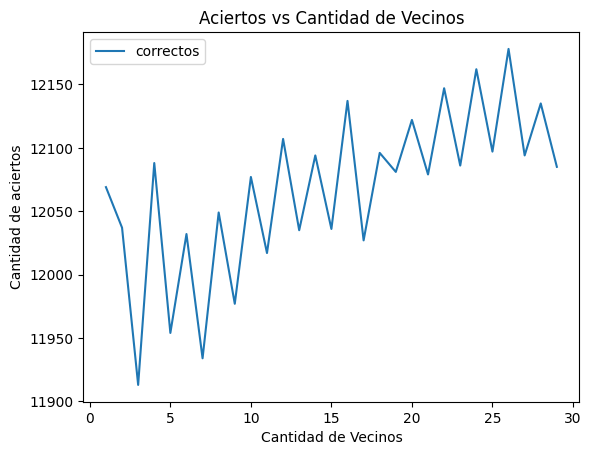

In [7]:
# ploteamos

df_metrics = pd.DataFrame(metrics, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos', 
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                     )

ax.set_ylabel("Cantidad de aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

In [ ]:
k_range = range(20,30) #cantidad de vecinos a probar

k_scores = [] # f1score para cada K utilizado
scorer_fn = make_scorer(sk.metrics.f1_score)

for k in k_range:
    #clasificador Knn
    knn = KNeighborsClassifier(n_neighbors=k)
    #uso 10 folds
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring=scorer_fn, verbose=2)
    #promedio las 10 métricas
    k_scores.append(scores.mean())

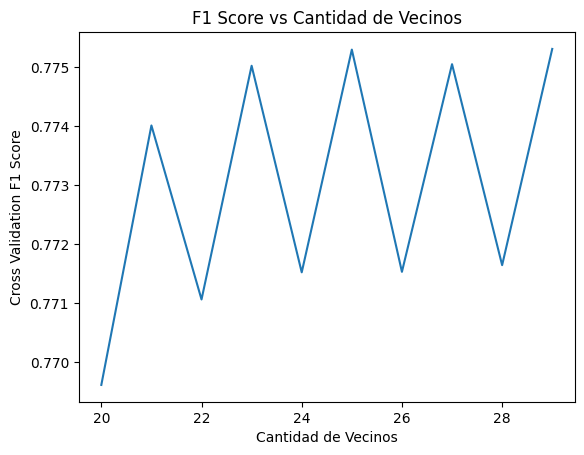

In [10]:
plt.plot(k_range, k_scores)
plt.xlabel('Cantidad de Vecinos')
plt.ylabel('Cross Validation F1 Score')
plt.title('F1 Score vs Cantidad de Vecinos')
plt.show()

### Random Search Cross Validation

In [16]:
#Cantidad de combinaciones que quiero probar
n=5

#Grilla de Parámetros
params_grid={ 'n_neighbors': [35], 
              'weights':['distance'],
              'algorithm':['kd_tree'],
              'metric':['manhattan'],
             }
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)

#Clasificador
knn_model = KNeighborsClassifier()

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
rand_knn = RandomizedSearchCV(estimator = knn_model,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              cv = kfoldcv,
                              n_iter = n,
                              random_state=RANDOM_STATE, verbose=2) 

rand_knn.fit(x_train, y_train)
rand_knn.cv_results_['mean_test_score']

c:\Program Files\Python38\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=50, weights=distance; total time=  15.2s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=50, weights=distance; total time=  13.0s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=50, weights=distance; total time=  17.4s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=50, weights=distance; total time=  15.2s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=50, weights=distance; total time=  11.7s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=50, weights=distance; total time=  19.1s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=50, weights=distance; total time=  13.1s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=50, weights=distance; total time=  10.5s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=50, weights=distance; total time=  13.2s
[CV] END algorithm=kd_tree, metric=manhattan, n_

array([0.62076846])

In [17]:
print('Mejores parámetros: {}'.format(rand_knn.best_params_))
print('Mejor métrica: {}'.format(rand_knn.best_score_))

Mejores parámetros: {'weights': 'distance', 'n_neighbors': 50, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
Mejor métrica: 0.6207684594738014


In [18]:
knn = KNeighborsClassifier().set_params(**rand_knn.best_params_)
modelo_knn = knn.fit(x_train, y_train)
y_pred = modelo_knn.predict(x_test)

In [ ]:
#pickle.dump(modelo_knn, open('knn_grupo29.pickle', 'wb'))

### Métricas

In [19]:
print(f'Best Training Accuracy: {modelo_knn.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {modelo_knn.score(x_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(rand_knn.best_estimator_, x, y, cv=StratifiedKFold(shuffle=True)).mean()}')

Best Training Accuracy: 1.0
Best Testing Accuracy: 0.623651191969887
Cross-val-score: 0.6212075959847223


In [20]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.623651191969887
Recall: 0.6133448445979279
Precision: 0.6345540385351538
f1 score: 0.623769206647852


In [21]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.61      0.63      0.62      7832
           1       0.63      0.61      0.62      8108

    accuracy                           0.62     15940
   macro avg       0.62      0.62      0.62     15940
weighted avg       0.62      0.62      0.62     15940



In [22]:
print(classification_report(y_train, modelo_knn.predict(x_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18275
           1       1.00      1.00      1.00     18917

    accuracy                           1.00     37192
   macro avg       1.00      1.00      1.00     37192
weighted avg       1.00      1.00      1.00     37192



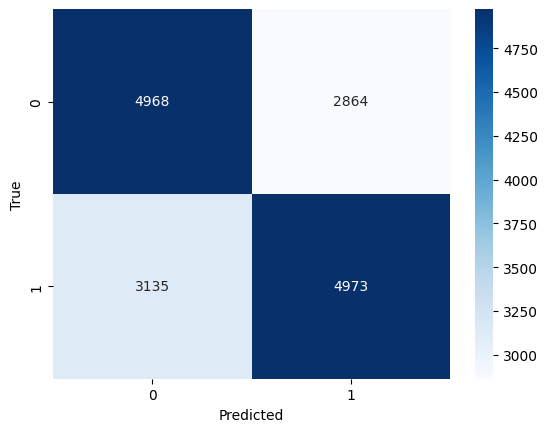

In [23]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Submission

In [27]:
X_submission_knn = test.select_dtypes(exclude=['object'])
y_pred_test_knn = modelo_knn.predict(X_submission_knn)
df_submission_knn = pd.DataFrame({'id': original_test['id'], 'is_canceled': y_pred_test_knn})
df_submission_knn.to_csv('knn00.csv', index=False)

## Support Vector Machine (SVM)

### Random Search Cross Validation

In [6]:
#Crear el modelo con parámetros por defecto
SVM_Classifier = SVC()

In [7]:
#Entrenar el modelo
SVM_Classifier.fit(x_train, y_train)

#Predicción sobre test
y_pred = SVM_Classifier.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("f1 score: "+str(f1))

### Random Search

In [ ]:
#Cantidad de combinaciones que quiero probar
n=5

#Grilla de Parámetros
params_grid= {'kernel': ['linear'],
              'C': [10]
              }

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)

#Clasificador
knn_model = SVC()

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
rand_svm = RandomizedSearchCV(estimator = knn_model,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              n_iter = n,
                              random_state=RANDOM_STATE, verbose=2) 

rand_svm.fit(x_train, y_train)
rand_svm.cv_results_['mean_test_score']

In [ ]:
print('Mejores parámetros: {}'.format(rand_svm.best_params_))
print('Mejor métrica: {}'.format(rand_svm.best_score_))

In [ ]:
svm = SVC(random_state=RANDOM_STATE).set_params(**rand_svm.best_params_)
modelo_svm = svm.fit(x_train, y_train)
y_pred = modelo_svm.predict(x_test)

In [ ]:
#pickle.dump(modelo_svm, open('svm_grupo29.pickle', 'wb'))

### Métricas

In [ ]:
print(f'Best Training Accuracy: {modelo_svm.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {modelo_svm.score(x_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(rand_svm.best_estimator_, x, y, cv=StratifiedKFold(shuffle=True)).mean()}')

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

In [ ]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

In [ ]:
print(classification_report(y_train, modelo_svm.predict(x_train)))

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Submission

In [ ]:
X_submission_svm = test.select_dtypes(exclude=['object'])
y_pred_test_svm = modelo_svm.predict(X_submission_svm)
df_submission_svm = pd.DataFrame({'id': original_test['id'], 'is_canceled': y_pred_test_svm})
df_submission_svm.to_csv('svm00.csv', index=False)

## Random Forest

In [10]:
modelo_rf = RandomForestClassifier()
modelo_rf.fit(x_train, y_train)
  
y_pred = modelo_rf.predict(x_test)

In [11]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("f1 score: "+str(f1))

Accuracy: 0.8741530740276036
f1 score: 0.8746719980007497


### Random Search Cross Validation

In [12]:
#Cantidad de combinaciones que quiero probar
n=5

#Grilla de Parámetros
params_grid={ 'n_estimators':      list(range(10,161,10)),
                'min_samples_split': list(range(2,15)),
                'ccp_alpha':         np.linspace(0,0.05,n), 
                'max_depth':         list(range(2,25)),
                'max_samples':       np.linspace(0.5,1,n)
             }
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)

#Clasificador
modelo_rf = RandomForestClassifier()

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
rand_rf = RandomizedSearchCV(estimator = modelo_rf,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              cv = kfoldcv,
                              n_iter = n,
                              random_state=RANDOM_STATE, verbose=2) 

rand_rf.fit(x_train, y_train)
rand_rf.cv_results_['mean_test_score']

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] END ccp_alpha=0.0, max_depth=17, max_samples=0.5, min_samples_split=14, n_estimators=40; total time=   4.7s
[CV] END ccp_alpha=0.0, max_depth=17, max_samples=0.5, min_samples_split=14, n_estimators=40; total time=   3.3s
[CV] END ccp_alpha=0.0, max_depth=17, max_samples=0.5, min_samples_split=14, n_estimators=40; total time=   3.1s
[CV] END ccp_alpha=0.0, max_depth=17, max_samples=0.5, min_samples_split=14, n_estimators=40; total time=   2.9s
[CV] END ccp_alpha=0.0, max_depth=17, max_samples=0.5, min_samples_split=14, n_estimators=40; total time=   3.2s
[CV] END ccp_alpha=0.0, max_depth=17, max_samples=0.5, min_samples_split=14, n_estimators=40; total time=   3.5s
[CV] END ccp_alpha=0.0, max_depth=17, max_samples=0.5, min_samples_split=14, n_estimators=40; total time=   4.6s
[CV] END ccp_alpha=0.0, max_depth=17, max_samples=0.5, min_samples_split=14, n_estimators=40; total time=   3.0s
[CV] END ccp_alpha=0.0, max_depth=1

array([0.84621963, 0.70380041, 0.64592722, 0.66848874, 0.65552078])

In [13]:
print('Mejores parámetros: {}'.format(rand_rf.best_params_))
print('Mejor métrica: {}'.format(rand_rf.best_score_))

Mejores parámetros: {'n_estimators': 40, 'min_samples_split': 14, 'max_samples': 0.5, 'max_depth': 17, 'ccp_alpha': 0.0}
Mejor métrica: 0.8462196318400574


In [14]:
rf = RandomForestClassifier(random_state=RANDOM_STATE).set_params(**rand_rf.best_params_)
modelo_rf = rf.fit(x_train, y_train)
y_pred = modelo_rf.predict(x_test)

In [ ]:
#pickle.dump(modelo_rf, open('rf_grupo29.pickle', 'wb'))

### Métricas

In [15]:
print(f'Best Training Accuracy: {modelo_rf.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {modelo_rf.score(x_test, y_test)}')
#print(f'Cross-val-score: {cross_val_score(rand_rf.best_estimator_, x, y, cv=StratifiedKFold(shuffle=True)).mean()}')

Best Training Accuracy: 0.8702677995267799
Best Testing Accuracy: 0.8467377666248431


In [16]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8467377666248431
Recall: 0.8244943265910212
Precision: 0.8676184295911745
f1 score: 0.8455068614431164


In [17]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      7832
           1       0.87      0.82      0.85      8108

    accuracy                           0.85     15940
   macro avg       0.85      0.85      0.85     15940
weighted avg       0.85      0.85      0.85     15940



In [18]:
print(classification_report(y_train, modelo_rf.predict(x_train)))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87     18275
           1       0.89      0.85      0.87     18917

    accuracy                           0.87     37192
   macro avg       0.87      0.87      0.87     37192
weighted avg       0.87      0.87      0.87     37192



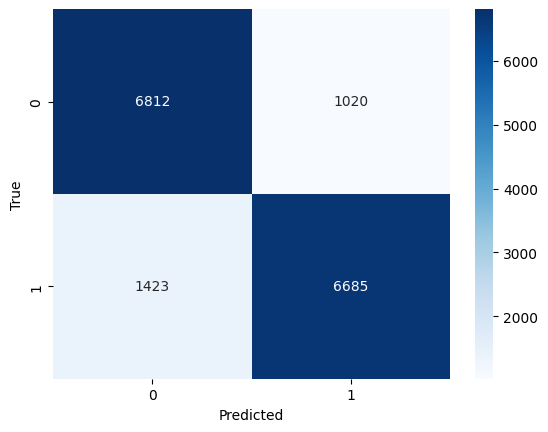

In [19]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Visualizacion del árbol

In [22]:
feat_imps = rf.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,x.columns), reverse=True):
  if feat_imp > 0.01:
    print('{}: {}'.format(feat,feat_imp))

deposit_type_No Deposit: 0.12553811123375674
lead_time: 0.08990418144231567
country_PRT: 0.08586130367189448
total_of_special_requests: 0.0628501538436088
deposit_type_Non Refund: 0.05674193404578629
agent: 0.0315396448822023
required_car_parking_spaces: 0.028884764790263927
previous_cancellations: 0.027121281636816673
adr: 0.026850039210674897
booking_changes: 0.026714768635682277
market_segment_Online TA: 0.02628983061064935
customer_type_Transient: 0.025373138511728822
market_segment_Offline TA/TO: 0.021001673515312937
market_segment_Groups: 0.02071851270503555
assigned_room_type_A: 0.018564855244749285
customer_type_Transient-Party: 0.016174090679617205
distribution_channel_TA/TO: 0.014775958612518264
stays_in_week_nights: 0.013641215844745916
arrival_date_year_2015: 0.012548546976804196
country_FRA: 0.011056163365199071
market_segment_Direct: 0.010629383434031909
country_GBR: 0.01057955687378109


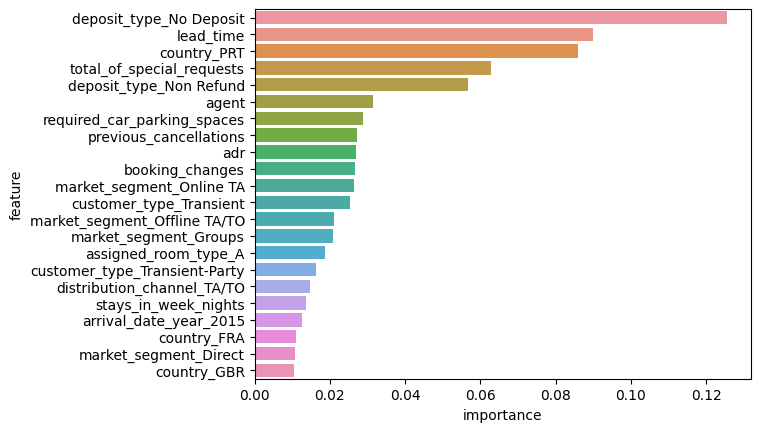

In [27]:
feat_imp_df = pd.DataFrame({'feature':x.columns,'importance':feat_imps})
feat_imp_df = feat_imp_df[feat_imp_df['importance']>0.01]
feat_imp_df = feat_imp_df.sort_values(by='importance',ascending=False)
sns.barplot(x='importance',y='feature',data=feat_imp_df)
plt.show()

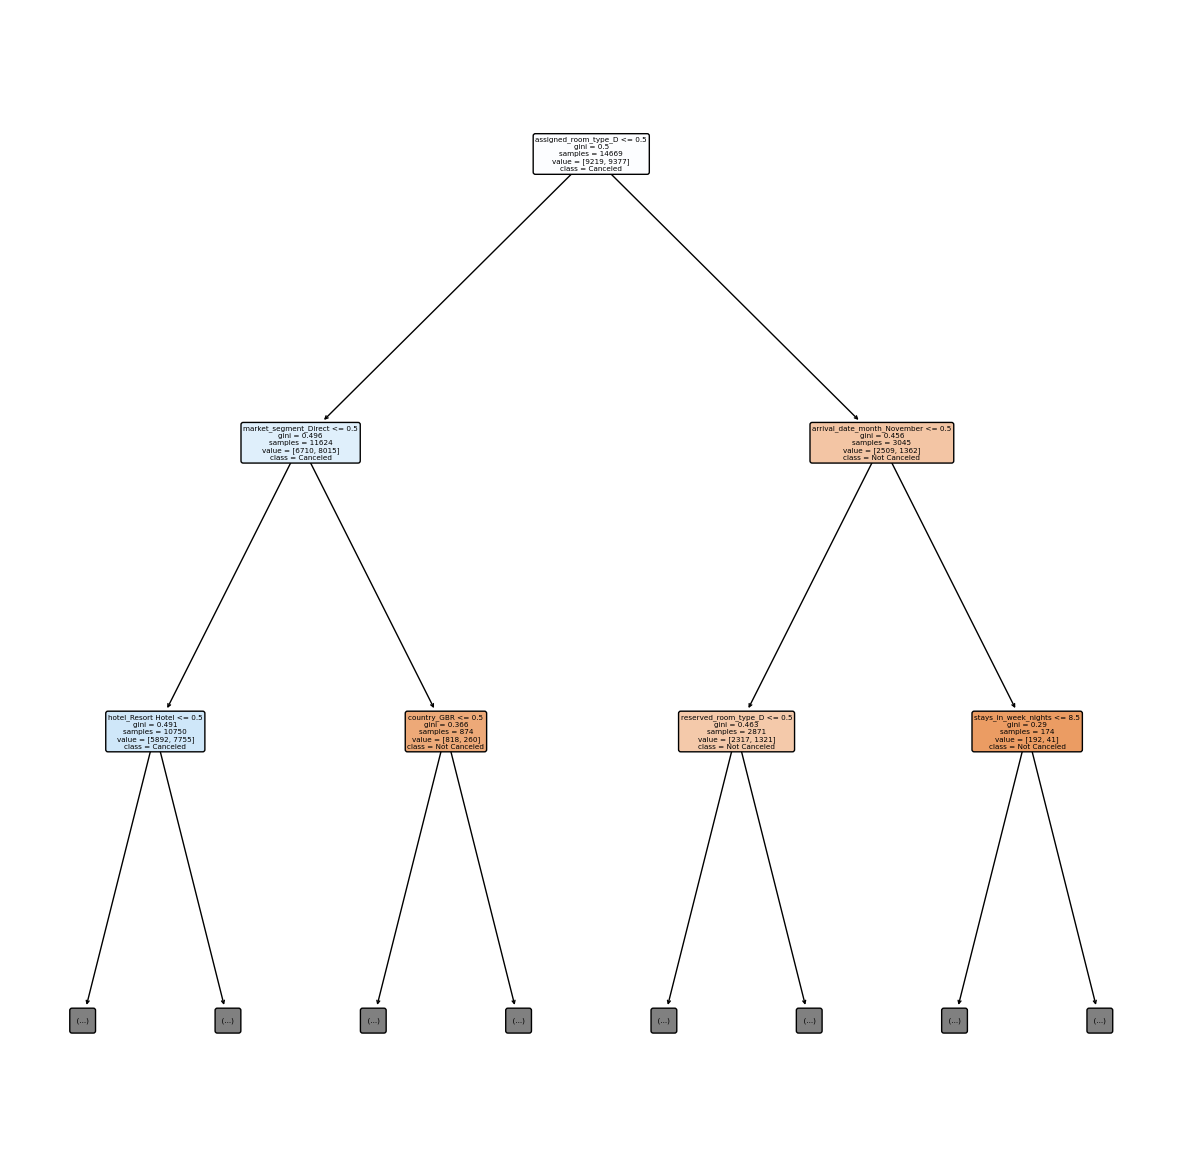

In [38]:
plt.figure(figsize=(15, 15))

tree_plot = plot_tree(modelo_rf.estimators_[0],
                           max_depth=2,
                           feature_names=x.columns.to_list(),
                           filled=True,
                           rounded=True,
                           class_names=['Not Canceled', 'Canceled'])
plt.show(tree_plot)

### Submission

In [27]:
X_submission_rf = test.select_dtypes(exclude=['object'])
y_pred_test_rf = modelo_rf.predict(X_submission_rf)
df_submission_rf = pd.DataFrame({'id': original_test['id'], 'is_canceled': y_pred_test_rf})
df_submission_rf.to_csv('rf01.csv', index=False)

## XGBoost